In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import logging
import re
from urllib.parse import urlparse
import warnings
import os
from pathlib import Path


In [2]:

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('phishing_detection.log'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

# Ensure output directory exists
OUTPUT_DIR = Path('model_outputs')
OUTPUT_DIR.mkdir(exist_ok=True)


In [3]:

def load_data(file_path):
    """Load and validate the phishing dataset."""
    try:
        logger.info(f"Loading dataset from {file_path}")
        df = pd.read_csv(file_path, sep=';')

        # Validate required columns
        required_columns = ['Type', 'url_length', 'number_of_dots_in_url', 'entropy_of_url', 'entropy_of_domain']
        if not all(col in df.columns for col in required_columns):
            raise ValueError("Dataset missing required columns")

        # Handle missing values
        df = df.dropna()

        # Ensure 'Type' is binary (0 or 1)
        if not df['Type'].isin([0, 1]).all():
            raise ValueError("Type column must contain only 0 or 1")

        logger.info(f"Dataset loaded successfully. Shape: {df.shape}")
        return df
    except Exception as e:
        logger.error(f"Error loading dataset: {str(e)}")
        raise


In [4]:

def preprocess_data(df):
    """Preprocess the dataset for model training."""
    try:
        logger.info("Preprocessing data...")

        # Separate features and target
        X = df.drop('Type', axis=1)
        y = df['Type']

        # Normalize numerical features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        logger.info("Data preprocessing completed.")
        return X_scaled, y, scaler, X.columns
    except Exception as e:
        logger.error(f"Error in preprocessing: {str(e)}")
        raise


In [5]:

def train_model(X, y):
    """Train a Random Forest model with hyperparameter tuning."""
    try:
        logger.info("Starting model training...")

        # Define parameter grid for GridSearchCV
        param_grid = {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }

        # Initialize Random Forest
        rf = RandomForestClassifier(random_state=42)

        # Perform grid search
        grid_search = GridSearchCV(
            estimator=rf,
            param_grid=param_grid,
            cv=5,
            n_jobs=-1,
            scoring='f1',
            verbose=1
        )

        grid_search.fit(X, y)

        # Get best model
        best_model = grid_search.best_estimator_

        # Perform cross-validation
        cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='f1')

        logger.info(f"Best parameters: {grid_search.best_params_}")
        logger.info(f"Cross-validation F1 scores: {cv_scores}")
        logger.info(f"Average CV F1 score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

        return best_model
    except Exception as e:
        logger.error(f"Error in model training: {str(e)}")
        raise


In [6]:

def evaluate_model(model, X_test, y_test):
    """Evaluate the model on test data."""
    try:
        logger.info("Evaluating model...")

        y_pred = model.predict(X_test)

        # Log classification report
        logger.info("\nClassification Report:")
        logger.info(classification_report(y_test, y_pred))

        # Log confusion matrix
        logger.info("\nConfusion Matrix:")
        logger.info(confusion_matrix(y_test, y_pred))

    except Exception as e:
        logger.error(f"Error in model evaluation: {str(e)}")
        raise


In [7]:

def save_model_and_scaler(model, scaler, feature_names):
    """Save the trained model, scaler, and feature names."""
    try:
        logger.info("Saving model and scaler...")

        joblib.dump(model, OUTPUT_DIR / 'phishing_model.pkl')
        joblib.dump(scaler, OUTPUT_DIR / 'scaler.pkl')
        joblib.dump(feature_names, OUTPUT_DIR / 'feature_names.pkl')

        logger.info("Model and scaler saved successfully.")
    except Exception as e:
        logger.error(f"Error saving model: {str(e)}")
        raise


In [8]:

def calculate_entropy(text):
    """Calculate Shannon entropy of a string."""
    if not text:
        return 0.0
    length = len(text)
    if length <= 1:
        return 0.0
    prob = [float(text.count(c)) / length for c in set(text)]
    return -sum(p * np.log2(p) for p in prob if p > 0)


In [9]:

def extract_url_features(url):
    """Extract features from a URL consistent with the dataset."""
    try:
        # Normalize URL: remove trailing slash and convert to lowercase
        url = url.rstrip('/').lower()
        parsed_url = urlparse(url)
        domain = parsed_url.netloc
        path = parsed_url.path
        query = parsed_url.query
        fragment = parsed_url.fragment

        # Initialize feature dictionary
        features = {}

        # URL-based features
        features['url_length'] = len(url)
        features['number_of_dots_in_url'] = url.count('.')
        features['having_repeated_digits_in_url'] = 1 if re.search(r'(\d)\1', url) else 0
        features['number_of_digits_in_url'] = sum(c.isdigit() for c in url)
        features['number_of_special_char_in_url'] = sum(not c.isalnum() and c != '.' for c in url)
        features['number_of_hyphens_in_url'] = url.count('-')
        features['number_of_underline_in_url'] = url.count('_')
        features['number_of_slash_in_url'] = url.count('/')
        features['number_of_questionmark_in_url'] = url.count('?')
        features['number_of_equal_in_url'] = url.count('=')
        features['number_of_at_in_url'] = url.count('@')
        features['number_of_dollar_in_url'] = url.count('$')
        features['number_of_exclamation_in_url'] = url.count('!')
        features['number_of_hashtag_in_url'] = url.count('#')
        features['number_of_percent_in_url'] = url.count('%')

        # Domain-based features
        features['domain_length'] = len(domain)
        features['number_of_dots_in_domain'] = domain.count('.')
        features['number_of_hyphens_in_domain'] = domain.count('-')
        features['having_special_characters_in_domain'] = 1 if any(not c.isalnum() and c != '.' and c != '-' for c in domain) else 0
        features['number_of_special_characters_in_domain'] = sum(not c.isalnum() and c != '.' and c != '-' for c in domain)
        features['having_digits_in_domain'] = 1 if any(c.isdigit() for c in domain) else 0
        features['number_of_digits_in_domain'] = sum(c.isdigit() for c in domain)
        features['having_repeated_digits_in_domain'] = 1 if re.search(r'(\d)\1', domain) else 0

        # Subdomain features
        subdomains = domain.split('.')[:-2]  # Exclude TLD and main domain
        features['number_of_subdomains'] = len(subdomains)
        features['having_dot_in_subdomain'] = 1 if any('.' in subd for subd in subdomains) else 0
        features['having_hyphen_in_subdomain'] = 1 if any('-' in subd for subd in subdomains) else 0
        features['average_subdomain_length'] = np.mean([len(subd) for subd in subdomains]) if subdomains else 0
        features['average_number_of_dots_in_subdomain'] = np.mean([subd.count('.') for subd in subdomains]) if subdomains else 0
        features['average_number_of_hyphens_in_subdomain'] = np.mean([subd.count('-') for subd in subdomains]) if subdomains else 0
        features['having_special_characters_in_subdomain'] = 1 if any(not c.isalnum() and c != '.' and c != '-' for subd in subdomains for c in subd) else 0
        features['number_of_special_characters_in_subdomain'] = sum(not c.isalnum() and c != '.' and c != '-' for subd in subdomains for c in subd)
        features['having_digits_in_subdomain'] = 1 if any(c.isdigit() for subd in subdomains for c in subd) else 0
        features['number_of_digits_in_subdomain'] = sum(c.isdigit() for subd in subdomains for c in subd)
        features['having_repeated_digits_in_subdomain'] = 1 if any(re.search(r'(\d)\1', subd) for subd in subdomains) else 0

        # Path and other features
        features['having_path'] = 1 if path else 0
        features['path_length'] = len(path)
        features['having_query'] = 1 if query else 0
        features['having_fragment'] = 1 if fragment else 0
        features['having_anchor'] = 1 if '#' in url else 0

        # Entropy features
        features['entropy_of_url'] = calculate_entropy(url)
        features['entropy_of_domain'] = calculate_entropy(domain)

        return features
    except Exception as e:
        logger.error(f"Error extracting features from URL {url}: {str(e)}")
        raise


In [10]:

def test_url(url, model, scaler, feature_names):
    """Test an unseen URL for phishing."""
    try:
        logger.info(f"Testing URL: {url}")

        # Extract features
        features = extract_url_features(url)

        # Create DataFrame with correct feature order
        feature_df = pd.DataFrame([features])[feature_names]

        # Scale features
        features_scaled = scaler.transform(feature_df)

        # Predict
        prediction = model.predict(features_scaled)[0]
        probability = model.predict_proba(features_scaled)[0]

        result = {
            'url': url,
            'is_phishing': bool(prediction),
            'phishing_probability': float(probability[1]),
            'features': features
        }

        logger.info(f"Prediction: {'Phishing' if prediction else 'Safe'} (Probability: {probability[1]:.4f})")
        return result
    except Exception as e:
        logger.error(f"Error testing URL {url}: {str(e)}")
        raise


In [11]:
def main():
    """Main function to train the model and set up testing."""
    try:
        # Load data
        df = load_data('/content/phishng.csv')

        # Preprocess data
        X_scaled, y, scaler, feature_names = preprocess_data(df)

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y, test_size=0.2, random_state=42, stratify=y
        )

        # Train model
        model = train_model(X_train, y_train)

        # Evaluate model
        evaluate_model(model, X_test, y_test)

        # Save model and scaler
        save_model_and_scaler(model, scaler, feature_names)

        # Example: Test a URL
        test_urls = [
            'https://www.google.com/',
            'http://fake-login-page.com/login.php'
        ]

        for url in test_urls:
            result = test_url(url, model, scaler, feature_names)
            print(f"\nURL: {result['url']}")
            print(f"Prediction: {'Phishing' if result['is_phishing'] else 'Safe'}")
            print(f"Phishing Probability: {result['phishing_probability']:.4f}")

    except Exception as e:
        logger.error(f"Error in main execution: {str(e)}")
        raise


In [12]:

if __name__ == '__main__':
    main()

Fitting 5 folds for each of 24 candidates, totalling 120 fits

URL: https://www.google.com/
Prediction: Safe
Phishing Probability: 0.3050

URL: http://fake-login-page.com/login.php
Prediction: Phishing
Phishing Probability: 0.6300


In [15]:
import joblib

# Load saved model, scaler, and feature names
model = joblib.load('model_outputs/phishing_model.pkl')
scaler = joblib.load('model_outputs/scaler.pkl')
feature_names = joblib.load('model_outputs/feature_names.pkl')

In [28]:
test_url( 'https://learn1.bue.edu.eg/login/index.php',model,scaler,feature_names)

{'url': 'https://learn1.bue.edu.eg/login/index.php',
 'is_phishing': False,
 'phishing_probability': 0.25,
 'features': {'url_length': 41,
  'number_of_dots_in_url': 4,
  'having_repeated_digits_in_url': 0,
  'number_of_digits_in_url': 1,
  'number_of_special_char_in_url': 5,
  'number_of_hyphens_in_url': 0,
  'number_of_underline_in_url': 0,
  'number_of_slash_in_url': 4,
  'number_of_questionmark_in_url': 0,
  'number_of_equal_in_url': 0,
  'number_of_at_in_url': 0,
  'number_of_dollar_in_url': 0,
  'number_of_exclamation_in_url': 0,
  'number_of_hashtag_in_url': 0,
  'number_of_percent_in_url': 0,
  'domain_length': 17,
  'number_of_dots_in_domain': 3,
  'number_of_hyphens_in_domain': 0,
  'having_special_characters_in_domain': 0,
  'number_of_special_characters_in_domain': 0,
  'having_digits_in_domain': 1,
  'number_of_digits_in_domain': 1,
  'having_repeated_digits_in_domain': 0,
  'number_of_subdomains': 2,
  'having_dot_in_subdomain': 0,
  'having_hyphen_in_subdomain': 0,
  'av

Model Accuracy: 0.9668 (96.68%)

Confusion Matrix:
[[25006   702]
 [  946 22936]]


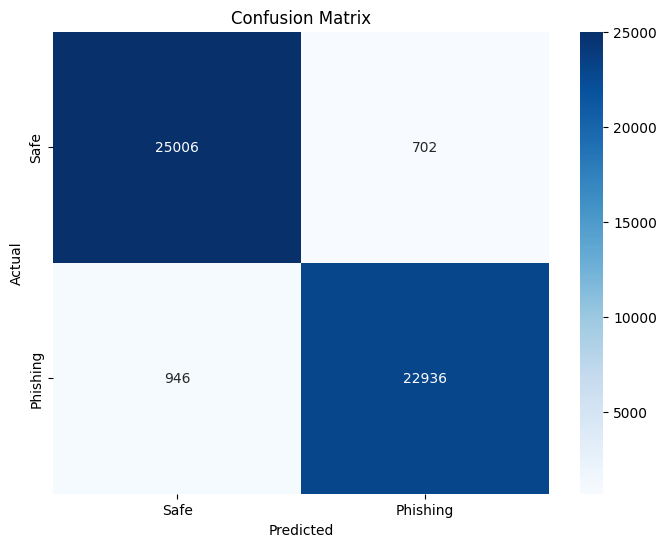

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv('/content/phishng.csv', sep=';')
if not all(col in df.columns for col in ['Type', 'url_length', 'number_of_dots_in_url']):
    raise ValueError("Dataset missing required columns")
df = df.dropna()
if not df['Type'].isin([0, 1]).all():
    raise ValueError("Type column must contain only 0 or 1")

# Preprocess data
X = df.drop('Type', axis=1)
y = df['Type']
scaler = joblib.load('model_outputs/scaler.pkl')
X_scaled = scaler.transform(X)

# Split data (same as training)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Load model
model = joblib.load('model_outputs/phishing_model.pkl')

# Evaluate
y_pred = model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Safe', 'Phishing'], yticklabels=['Safe', 'Phishing'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [30]:
from google.colab import files
files.download('model_outputs/phishing_model.pkl')
files.download('model_outputs/scaler.pkl')
files.download('model_outputs/feature_names.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>